# **Pharmaceutical Sales prediction across multiple stores**

**Forecasting Sales is a essential use of Machine Learning(ML).Sales forecasts can be used to identify benchmarks and determine incremental impacts of new initiatives, plan resources in response to expected demand and project future budgets.**

## **Table of contents**
     1. Exploring the data and Data Pre-processing
     2. Building models with sklearn pipelines
     3. Choose a loss function
     4. Post Prediction analysis
     5. Serialize models

 ## **1. Data Preprocessing**

  1.1 Importing Libraries

In [1]:
#!pip install category_encoders
import pandas as pd
import seaborn as sns
#!pip install category_encoders
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import numpy as np 
import matplotlib.pyplot as plt
import category_encoders as ce
%matplotlib inline

In [2]:
train_data=pd.read_csv(r'C:\Users\HP\Desktop\Projects\Machine_Hotshots\notebook\data\Output.csv')

In [3]:
train_data.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,...,Store-1,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,23,6,867,3,6/3/2015,5608,469,1,1,...,867,d,c,21810.0,9.0,2012.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
1,1,23,6,868,3,6/3/2015,13500,816,1,1,...,868,d,c,1360.0,8.0,2005.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct"
2,1,23,6,869,3,6/3/2015,7007,932,1,1,...,869,c,a,230.0,10.0,2001.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,1,23,6,870,3,6/3/2015,7911,971,1,1,...,870,a,a,780.0,4.0,2009.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
4,1,23,6,871,3,6/3/2015,9198,678,1,1,...,871,d,c,10620.0,NaN,NaN,0,NaN,NaN,"Jan,Apr,Jul,Oct"


**1.2 Cleansing the Data**

   1.2.1 Handling Null values

In [4]:
#Checking the no. of NaN values
train_data.isna().sum()

Weekdays                          0
Weeks                             0
Months                            0
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                  31050
SchoolHoliday                     0
Store-1                           0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                     0
dtype: int64

1) CompetitionDistance:

* Before deciding how to treat this,we know there are infinite ways of filling missing values.
* The most common and simplistic approach is to fill it with either the mean or the median of this variable.
* Let's quickly have a look at those metrics.

In [5]:
train_data[pd.isnull(train_data.CompetitionDistance)].head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,...,Store-1,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
12,1,23,6,879,3,6/3/2015,5155,436,1,1,...,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"
411,1,47,11,291,3,11/19/2014,0,0,0,0,...,291,d,a,NaN,NaN,NaN,0,NaN,NaN,"Jan,Apr,Jul,Oct"
676,1,23,6,291,2,6/2/2015,9897,973,1,1,...,291,d,a,NaN,NaN,NaN,0,NaN,NaN,"Jan,Apr,Jul,Oct"
1007,1,23,6,622,2,6/2/2015,5389,470,1,1,...,622,a,c,NaN,NaN,NaN,0,NaN,NaN,"Jan,Apr,Jul,Oct"
1663,1,52,12,291,4,12/25/2014,0,0,0,0,...,291,d,a,NaN,NaN,NaN,0,NaN,NaN,"Jan,Apr,Jul,Oct"


In [6]:
df_store_check_distribution=train_data.drop(train_data[pd.isnull(train_data.CompetitionDistance)].index)
df_store_check_distribution.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,...,Store-1,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,23,6,867,3,6/3/2015,5608,469,1,1,...,867,d,c,21810.0,9.0,2012.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
1,1,23,6,868,3,6/3/2015,13500,816,1,1,...,868,d,c,1360.0,8.0,2005.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct"
2,1,23,6,869,3,6/3/2015,7007,932,1,1,...,869,c,a,230.0,10.0,2001.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,1,23,6,870,3,6/3/2015,7911,971,1,1,...,870,a,a,780.0,4.0,2009.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
4,1,23,6,871,3,6/3/2015,9198,678,1,1,...,871,d,c,10620.0,NaN,NaN,0,NaN,NaN,"Jan,Apr,Jul,Oct"


{'Mean': 5430.085652302903, 'Median': 2330.0, 'Standard Dev': 7715.31989799512}

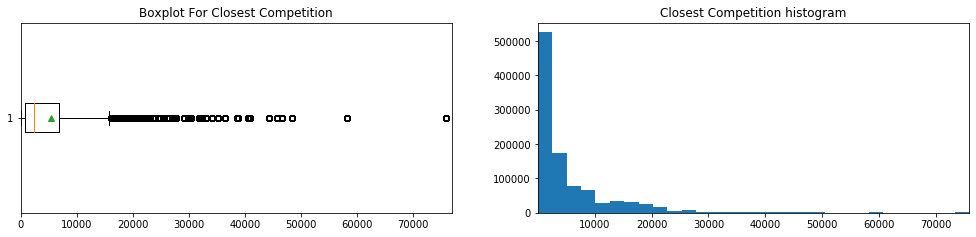

In [7]:
df_store_check_distribution=train_data.drop(train_data[pd.isnull(train_data.CompetitionDistance)].index)
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))
axes[0].boxplot(df_store_check_distribution.CompetitionDistance, showmeans=True,vert=False,)
axes[0].set_xlim(0,max(df_store_check_distribution.CompetitionDistance+1000))
axes[0].set_title('Boxplot For Closest Competition')
axes[1].hist(df_store_check_distribution.CompetitionDistance, cumulative=False, bins=30)
axes[1].set_title("Closest Competition histogram")
axes[1].set_xlim((min(df_store_check_distribution.CompetitionDistance), max(df_store_check_distribution.CompetitionDistance)))
{"Mean":np.nanmean(train_data.CompetitionDistance),"Median":np.nanmedian(train_data.CompetitionDistance),"Standard Dev":np.nanstd(train_data.CompetitionDistance)}#That's what i thought, very different values, let's see why 

We see a highly right skewed distribution for this variable with a significant difference between the mean and the median. This being caused by the amount of disperness in the data with a standard deviation of 7659, higher than the mean and the median.

**What do we do then?**

It is realistically better to input the median value to the Nan stores then the mean since the mean is biased by those outliers.

In [8]:
train_data['CompetitionDistance'].fillna(train_data['CompetitionDistance'].median(), inplace = True)

2) CompetitionOpenSinceMonth and CompetitionOpenSinceYear?

* Since we have no information whatsoever on those missing values and no accurate way of filling those values.
* A creative way could be to apply a multilabel classification algorithm and train on the non Nan fields and then predict what could be most probably the month and year for those fields. But this approach is computationally too long.
* So for this purpose those fields are going to be assigned to 0 .

In [9]:
train_data.CompetitionOpenSinceMonth.fillna(0, inplace = True)
train_data.CompetitionOpenSinceYear.fillna(0,inplace=True)

3) Promo2SinceWeek, Promo2SinceYear and PromoInterval ?



* This case is pretty straighforward, all the missing values comes from fields where Promo2=0 which means there are no continuous promotional activities for those stores.
* Having no promotion means those fields have to be 0 as well since they are linked to Promo2.

In [10]:
train_data.Promo2SinceWeek.fillna(0,inplace=True)
train_data.Promo2SinceYear.fillna(0,inplace=True)
train_data.PromoInterval.fillna(0,inplace=True)


4) StateHoliday

In [11]:
train_data.StateHoliday.fillna(0,inplace=True)

In [12]:
train_data.count(0)/train_data.shape[0] * 100

Weekdays                     100.0
Weeks                        100.0
Months                       100.0
Store                        100.0
DayOfWeek                    100.0
Date                         100.0
Sales                        100.0
Customers                    100.0
Open                         100.0
Promo                        100.0
StateHoliday                 100.0
SchoolHoliday                100.0
Store-1                      100.0
StoreType                    100.0
Assortment                   100.0
CompetitionDistance          100.0
CompetitionOpenSinceMonth    100.0
CompetitionOpenSinceYear     100.0
Promo2                       100.0
Promo2SinceWeek              100.0
Promo2SinceYear              100.0
PromoInterval                100.0
dtype: float64

**Now all the null values are imputed**

1.2.2 Handling Outliers

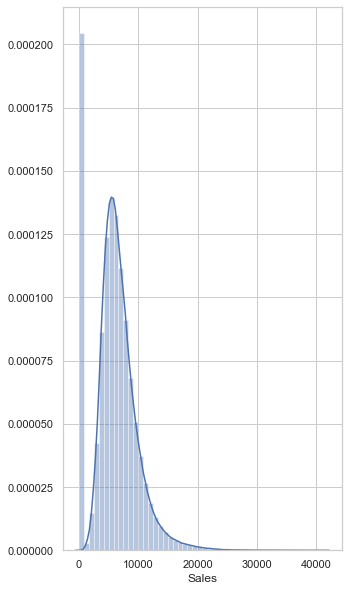

In [13]:
#Find the range of data
plt.figure(figsize=(5,10))
sns.set(style="whitegrid")
sns.distplot(train_data["Sales"])

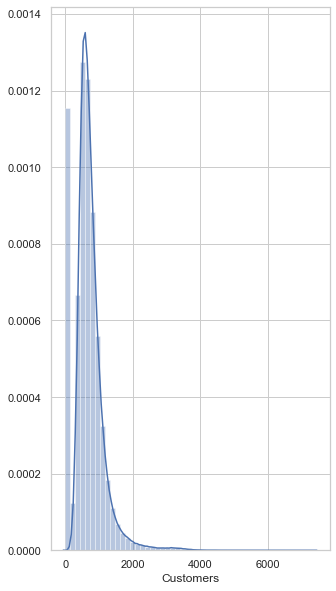

In [14]:
#Find the range of the data
plt.figure(figsize=(5,10))
sns.set(style="whitegrid")
sns.distplot(train_data["Customers"])

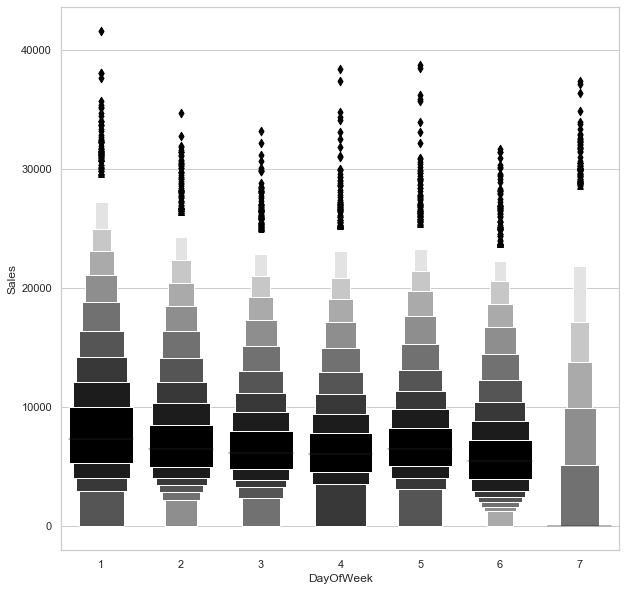

In [15]:
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.boxenplot(data=train_data,scale="linear",x="DayOfWeek",y="Sales",color="Black")

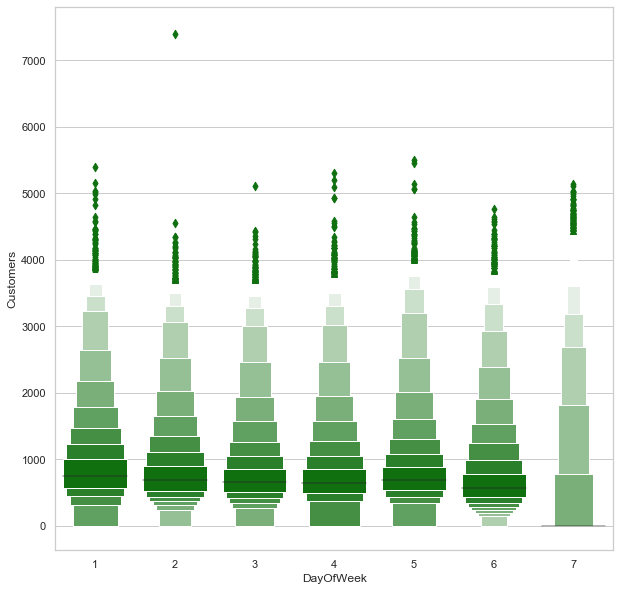

In [16]:
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.boxenplot(y="Customers", x="DayOfWeek",data=train_data, scale="linear",color="Green")

This data, contains many outliers, but these might have been caused to the surge of customers during a festival or Holiday, or due to an effective promo. 
Below we are handle the outliers

In [17]:
#Treating the outliers 
  # a function for replacing outliers with the median, used when there's too many outliers in a feature
def replace_outlier_with_median(dataFrame, feature):
    Q1 = dataFrame[feature].quantile(0.25)
    Q3 = dataFrame[feature].quantile(0.75)
    median = dataFrame[feature].quantile(0.50)

    IQR = Q3 - Q1

    upper_whisker = Q3 + (1.5 * IQR)
    lower_whisker = Q1 - (1.5 * IQR)

    dataFrame[feature] = np.where(dataFrame[feature] > upper_whisker, median, dataFrame[feature])
    dataFrame[feature] = np.where(dataFrame[feature] < lower_whisker, median, dataFrame[feature])

In [18]:
replace_outlier_with_median(train_data, 'Sales')

In [19]:
replace_outlier_with_median(train_data, 'Customers')

1.3 **Feature Engeneering**

Generating new features from already existing features. 



In [20]:
train_data.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,...,Store-1,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,23,6,867,3,6/3/2015,5608.0,469.0,1,1,...,867,d,c,21810.0,9.0,2012.0,0,0.0,0.0,"Jan,Apr,Jul,Oct"
1,1,23,6,868,3,6/3/2015,13500.0,816.0,1,1,...,868,d,c,1360.0,8.0,2005.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct"
2,1,23,6,869,3,6/3/2015,7007.0,932.0,1,1,...,869,c,a,230.0,10.0,2001.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,1,23,6,870,3,6/3/2015,7911.0,971.0,1,1,...,870,a,a,780.0,4.0,2009.0,0,0.0,0.0,"Jan,Apr,Jul,Oct"
4,1,23,6,871,3,6/3/2015,9198.0,678.0,1,1,...,871,d,c,10620.0,0.0,0.0,0,0.0,0.0,"Jan,Apr,Jul,Oct"


In [21]:
#Adding salespercustomer column
train_data['SalesperCustomer']=train_data['Sales']/train_data['Customers']

In [22]:
train_data.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalesperCustomer
0,1,23,6,867,3,6/3/2015,5608.0,469.0,1,1,...,d,c,21810.0,9.0,2012.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",11.957356
1,1,23,6,868,3,6/3/2015,13500.0,816.0,1,1,...,d,c,1360.0,8.0,2005.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct",16.544118
2,1,23,6,869,3,6/3/2015,7007.0,932.0,1,1,...,c,a,230.0,10.0,2001.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7.518240
3,1,23,6,870,3,6/3/2015,7911.0,971.0,1,1,...,a,a,780.0,4.0,2009.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",8.147271
4,1,23,6,871,3,6/3/2015,9198.0,678.0,1,1,...,d,c,10620.0,0.0,0.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",13.566372


In [23]:
train_data['Date'] = pd.to_datetime(train_data['Date'])

In [24]:
train_data['Year']=train_data.Date.dt.year

In [25]:
del train_data["Date"]
train_data.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,...,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalesperCustomer,Year
0,1,23,6,867,3,5608.0,469.0,1,1,0.0,...,c,21810.0,9.0,2012.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",11.957356,2015
1,1,23,6,868,3,13500.0,816.0,1,1,0.0,...,c,1360.0,8.0,2005.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct",16.544118,2015
2,1,23,6,869,3,7007.0,932.0,1,1,0.0,...,a,230.0,10.0,2001.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7.518240,2015
3,1,23,6,870,3,7911.0,971.0,1,1,0.0,...,a,780.0,4.0,2009.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",8.147271,2015
4,1,23,6,871,3,9198.0,678.0,1,1,0.0,...,c,10620.0,0.0,0.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",13.566372,2015


In [30]:
#correlation Analysis

In [26]:
df_correlation=train_data[['Store', 'DayOfWeek', 'Sales', 'Customers', 'Promo',
        'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'SalesperCustomer', 'Months', 'Year',
       'StateHoliday', 'Assortment', 'StoreType',
       'PromoInterval']]


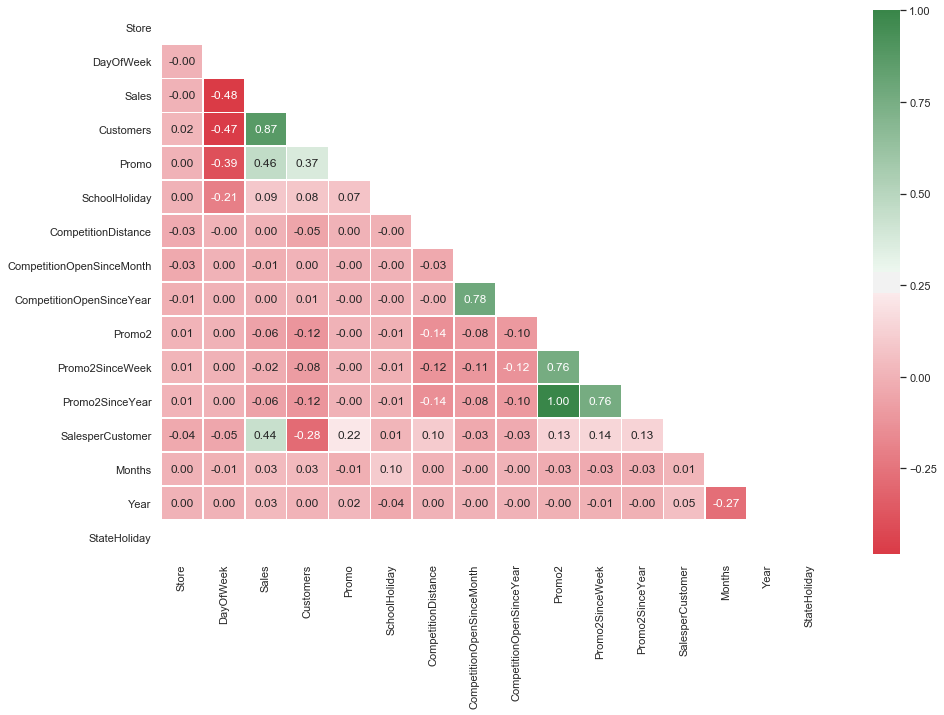

In [27]:
upper_triangle = np.zeros_like(df_correlation.corr(), dtype = np.bool)
upper_triangle[np.triu_indices_from(upper_triangle)] = True #make sure we don't show half of the other triangle
f, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(df_correlation.corr(),ax=ax,mask=upper_triangle,annot=True, fmt='.2f',linewidths=0.5,cmap=sns.diverging_palette(10, 133, as_cmap=True))


-Since the competition variables CompetitionOpenSinceYear and CompeitionOpenSinceMonth have the same underlying meaning, merging them into one variable that we call CompetitionOpenSince makes easier for the algorithm to understand the pattern and creates less branches and thus complex trees.

In [28]:
train_data['CompetitionOpenSince'] = np.where((train_data['CompetitionOpenSinceMonth']==0) & 
                                                  (train_data['CompetitionOpenSinceYear']==0) , 0,
                                                  (train_data.Months - train_data.CompetitionOpenSinceMonth) 
                                                  + (12 * (train_data.Year - train_data.CompetitionOpenSinceYear)) )

In [29]:
#train_data['Date'] = train_data['Date'].dt.strftime('%Y-%m-%d')

In [30]:
del train_data['CompetitionOpenSinceYear']
del train_data['CompetitionOpenSinceMonth']

In [55]:
train_data.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,...,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec","PromoInterval_Feb,May,Aug,Nov",SalesperCustomer,Year,CompetitionOpenSince
0,1,23,6,867,3,5608.0,469.0,1,1,0.0,...,21810.0,0,0.0,0.0,1,0,0,11.957356,2015,33.0
1,1,23,6,868,3,13500.0,816.0,1,1,0.0,...,1360.0,1,10.0,2014.0,1,0,0,16.544118,2015,118.0
2,1,23,6,869,3,7007.0,932.0,1,1,0.0,...,230.0,1,14.0,2011.0,1,0,0,7.518240,2015,164.0
3,1,23,6,870,3,7911.0,971.0,1,1,0.0,...,780.0,0,0.0,0.0,1,0,0,8.147271,2015,74.0
4,1,23,6,871,3,9198.0,678.0,1,1,0.0,...,10620.0,0,0.0,0.0,1,0,0,13.566372,2015,0.0


1.4 **Data Scaling and Data Encoding**

In [32]:
train_data.dtypes

Weekdays                  int64
Weeks                     int64
Months                    int64
Store                     int64
DayOfWeek                 int64
Sales                   float64
Customers               float64
Open                      int64
Promo                     int64
StateHoliday            float64
SchoolHoliday             int64
Store-1                   int64
StoreType                object
Assortment               object
CompetitionDistance     float64
Promo2                    int64
Promo2SinceWeek         float64
Promo2SinceYear         float64
PromoInterval            object
SalesperCustomer        float64
Year                      int64
CompetitionOpenSince    float64
dtype: object

In [54]:
# create an object of the OneHotEncoder
OHE = ce.OneHotEncoder(cols=['StoreType','Assortment','PromoInterval'],use_cat_names=True)
# encode the categorical variables
train_data = OHE.fit_transform(train_data)

train_data.head()

KeyError: 'StoreType'

So far we have taken care of the missing values and the categorical (string) variables in the data. Next we will work with the continuous variables. Often the continuous variables in the data have different scales, for instance, a variable V1 can have a range from 0 to 1 while another variable can have a range from 0-1000.

Based on the type of model you are building, you will have to normalize the data in such a way that the range of all the variables is almost similar. You can do this easily in python using the StandardScaler function.
For this project we will be using Random Forest Regressor

**2. Building models with sklearn pipelines**

Defining independent and dependent variables
let independent/Features = X
let dependent/Target = Y
SInce we want to predict store sales, the target/ dependent variable is sales. For features we remove all columns that are strongly correlated to sales. From correlation analysis, we see that "customers" and "salespercustomer"  have a strong positive correlation with sale. There we do away with these columns.

In [56]:
X = train_data.drop(['Customers', 'Sales', 'SalesperCustomer'], axis = 1)

In [57]:
X.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Store-1,...,Assortment_b,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec","PromoInterval_Feb,May,Aug,Nov",Year,CompetitionOpenSince
0,1,23,6,867,3,1,1,0.0,0,867,...,0,21810.0,0,0.0,0.0,1,0,0,2015,33.0
1,1,23,6,868,3,1,1,0.0,0,868,...,0,1360.0,1,10.0,2014.0,1,0,0,2015,118.0
2,1,23,6,869,3,1,1,0.0,0,869,...,0,230.0,1,14.0,2011.0,1,0,0,2015,164.0
3,1,23,6,870,3,1,1,0.0,0,870,...,0,780.0,0,0.0,0.0,1,0,0,2015,74.0
4,1,23,6,871,3,1,1,0.0,0,871,...,0,10620.0,0,0.0,0.0,1,0,0,2015,0.0


In [58]:

y=np.log(train_data.Sales)
y

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


0          8.631949
1          9.510445
2          8.854665
3          8.976009
4          9.126741
5          9.299358
6          8.451053
7          8.579604
8          8.963288
9          9.346705
10         8.974365
11         9.169414
12         8.547722
13         9.132163
14         8.692826
15         8.970178
16         8.743053
17         8.976389
18         8.946635
19         9.086816
20         9.083189
21         9.238733
22         8.427925
23         9.040382
24         9.117677
25         8.978030
26         8.986697
27         9.395242
28         9.367857
29         8.910990
             ...   
1017179    8.629450
1017180    9.195836
1017181    8.532279
1017182    8.993552
1017183    8.054840
1017184    8.655911
1017185    9.257796
1017186    8.829958
1017187    8.771990
1017188    9.402447
1017189    8.958025
1017190    9.101306
1017191    9.282010
1017192    9.042158
1017193    8.740657
1017194    8.529122
1017195    9.310729
1017196    8.787983
1017197    8.950533


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)
print ("Training and testing split was successful.")

Training and testing split was successful.


* Feature Scaling 

In [60]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [61]:
def rmspe(y, result):
    rmspe = np.sqrt(np.mean( (y - result)**2 ))
    return rmspe

In [64]:
def _assert_all_finite(X):
    """Like assert_all_finite, but only for ndarray."""
    X = np.asanyarray(X)
    # First try an O(n) time, O(1) space solution for the common case that
    # everything is finite; fall back to O(n) space np.isfinite to prevent
    # false positives from overflow in sum method.
    if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
            and not np.isfinite(X).all()):
        raise ValueError("Input contains NaN, infinity"
                         " or a value too large for %r." % X.dtype)

In [65]:
_assert_all_finite(y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [66]:
y_train.mean()

-inf

In [67]:
y_train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [68]:
y_train.fillna(8.72337779729373, inplace=True)

In [69]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=10, 
                             criterion='mse',random_state=0)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [47]:
y_pred = regressor.predict(X_test)
y_pred_l = pd.DataFrame(y_pred, columns=["sales prediction"])
print(y_pred_l.head())
y_test.head()

   sales prediction
0          8.707926
1          8.723378
2          8.215211
3          8.512830
4          8.451766


991178    8.581669
4941          -inf
493413    8.271548
264865    8.488999
737476    8.558143
Name: Sales, dtype: float64

In [48]:
y_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [49]:
y_test.mean()

8.72300394846444

In [50]:
y_test.fillna(8.72300394846444, inplace=True)

In [51]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.08714449126907711
Mean Squared Error: 0.020065108796858314
Root Mean Squared Error: 0.14165136355453242


### Validation

In [95]:
test = pd.read_csv(r"C:\Users\HP\Desktop\CV, P.Statement and others\10 Academy\week 5\test.csv\test.csv", parse_dates=['Date'])
store = pd.read_csv(r"C:\Users\HP\Desktop\CV, P.Statement and others\10 Academy\week 5\store.csv")


In [96]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [97]:
test.fillna(1, inplace = True)

In [99]:
test['Months']=test.Date.dt.month
test['Year']=test.Date.dt.year
test['week']=test.Date.dt.week
test['weekday']=test.Date.dt.weekday

In [100]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Months,Year,week,weekday
0,1,1,4,2015-09-17,1.0,1,0,0,9,2015,38,3
1,2,3,4,2015-09-17,1.0,1,0,0,9,2015,38,3
2,3,7,4,2015-09-17,1.0,1,0,0,9,2015,38,3
3,4,8,4,2015-09-17,1.0,1,0,0,9,2015,38,3
4,5,9,4,2015-09-17,1.0,1,0,0,9,2015,38,3


In [101]:
#merging test and store data
test_data = pd.merge(test, store, how = 'left', on = 'Store')

In [102]:
test_data.isnull().sum()

Id                               0
Store                            0
DayOfWeek                        0
Date                             0
Open                             0
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
Months                           0
Year                             0
week                             0
weekday                          0
StoreType                        0
Assortment                       0
CompetitionDistance             96
CompetitionOpenSinceMonth    15216
CompetitionOpenSinceYear     15216
Promo2                           0
Promo2SinceWeek              17232
Promo2SinceYear              17232
PromoInterval                17232
dtype: int64

In [103]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Months,Year,...,weekday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,9,2015,...,3,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,9,2015,...,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,9,2015,...,3,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,9,2015,...,3,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,9,2015,...,3,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [104]:
#dealing with missing values
test_data['CompetitionDistance'].fillna(test_data['CompetitionDistance'].median(), inplace = True)

In [105]:
test_data.CompetitionOpenSinceMonth.fillna(0, inplace = True)
test_data.CompetitionOpenSinceYear.fillna(0,inplace=True)

In [106]:
test_data.Promo2SinceWeek.fillna(0,inplace=True)
test_data.Promo2SinceYear.fillna(0,inplace=True)
test_data.PromoInterval.fillna(0,inplace=True)


In [107]:
test_data.isnull().sum()

Id                           0
Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
Months                       0
Year                         0
week                         0
weekday                      0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64